In [1]:
library(tidyverse)
library(networkD3)
library(htmlwidgets)
library(RColorBrewer)
library(ggrepel)
# library(ggthemes)
library(cowplot)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'htmlwidgets'


The following object is masked from 'package:networkD3':

    JS




In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
project <- c("CESC", "UCS", "UCEC")
dset_paths <- unlist(map(dsets, function(d) paste0(dirs$data_dir, "/", d)))
matrisome_list <- matrisome_list <- paste(dirs$data_dir, "matrisome", "matrisome_hs_masterlist.tsv", sep = "/")

In [3]:
dset_idx <- 3

In [4]:
text_size <- 11
guide_size <- 4
family <- "arial"
dpi <- 320
vp_ht <- 3
vp_wd <- 5

# Functions

In [5]:
to_vplot_df <- function(df, padj_thresh = 0.05, log2_fc_thresh = log2(2)) {
    vplot_df <- df %>%
        dplyr::rename(log2_fc = log2FoldChange) %>%
        dplyr::rename(gene_ID = geneID) %>%
        dplyr::rename(base_mean = baseMean) %>%
        dplyr::mutate(neg_log10_padj = -log10(padj)) %>%
        dplyr::select(gene_ID, base_mean, log2_fc, neg_log10_padj, padj, qval, pvalue) %>%
        dplyr::mutate(DE = case_when(
            (qval < padj_thresh) & (log2_fc > log2_fc_thresh) ~ "Up",
            (qval < padj_thresh) & (log2_fc < -log2_fc_thresh) ~ "Down",
            TRUE ~ "Not Sig."
        ))
    return(vplot_df)
}


make_vplot <- function(df, point_size = 0.25, hide_legend = TRUE, padj_thresh = 1e-10, neg_log10_padj_outlier_thresh = 100) {    
    plt <- ggplot(data = df %>% dplyr::filter(neg_log10_padj < neg_log10_padj_outlier_thresh)) +
        geom_point(aes(y = neg_log10_padj, x = log2_fc, color = DE), size = point_size) +
        scale_color_manual(name = "DE", values = c("Not Sig." = "gray30", "Up" = "firebrick3", "Down" = "steelblue3")) +
        guides(color = guide_legend(override.aes = list(size = guide_size))) +
        labs(
            y = bquote(paste(-log[10], "(", italic(q), "-val)")),
            x = bquote(paste(log[2], " fold-change"))
        ) +
        theme_classic() +
        theme(
            text = element_text(size = text_size, family = family),
            legend.title = element_blank(),
#             legend.background = element_blank(),
            legend.position = "right",
        )

    return(plt)
}

# Load data

In [6]:
dge_res_df <- read_tsv(paste0(dirs$analysis_dir, "/deg/", dsets[dset_idx], "_DESeq_results.tsv"))
counts_df <- read_tsv(paste0(dirs$data_dir, "/", dsets[dset_idx], "/counts.tsv")) %>%
    dplyr::rename("geneID" = "Hugo_Symbol") %>%
    dplyr::select(-"Entrez_Gene_Id")
matrisome_df <- rutils::load_matrisome_df(matrisome_list)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  qval = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  Hugo_Symbol = col_character()
)
i Use `spec()` for the full column specifications.



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthol

In [7]:
all_genes_in_dset <- counts_df$geneID
matrisome_summary_df <- matrisome_df %>%
    # Which matrisome genes were in the dataset?
    mutate(
        in_unified_dataset = dplyr::case_when(
            gene_symbol %in% all_genes_in_dset ~ TRUE,
            !(gene_symbol %in% all_genes_in_dset) ~ FALSE
        )
    ) %>%
    # Which matrisome genes were lowly expressed?
    left_join(dge_res_df, by = c("gene_symbol" = "geneID"), keep = TRUE) %>%
    mutate(lowly_expressed = is.na(geneID)) %>%
    dplyr::select(-geneID) %>%
    dplyr::select(gene_symbol, in_unified_dataset, lowly_expressed, everything()) %>%
    dplyr::rename(geneID = gene_symbol)

# Volcano plots

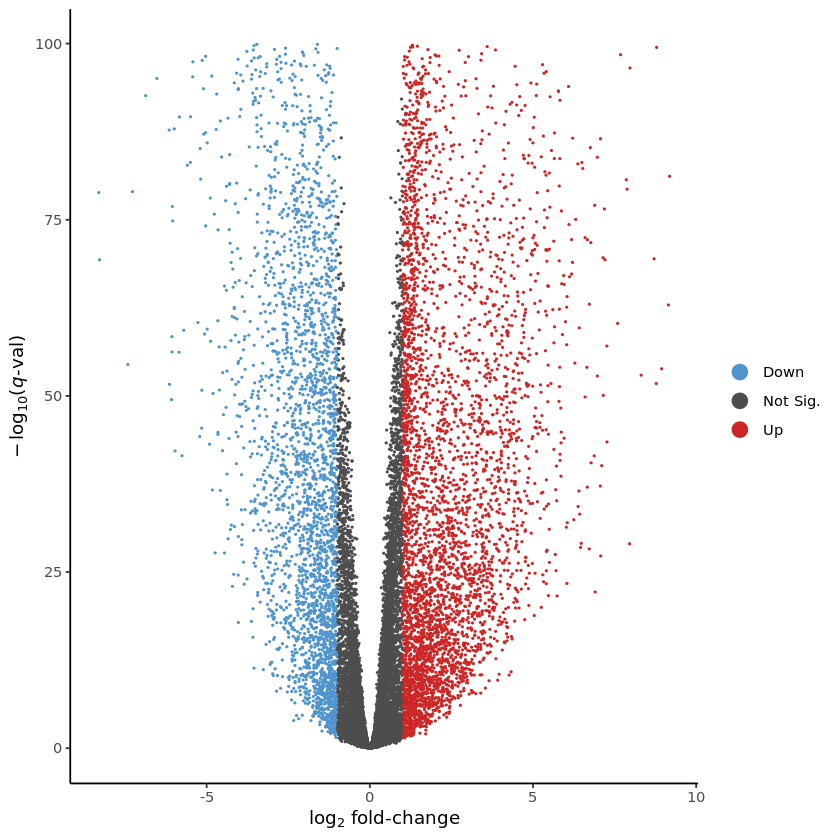

In [8]:
dge_res_df %>%
    to_vplot_df() %>%
    make_vplot()
ggsave(paste0(dirs$figures_dir, "/deg/", dsets[dset_idx], "_all_genes_vplot.png"), last_plot(), height = vp_ht, width = vp_wd, dpi = dpi)

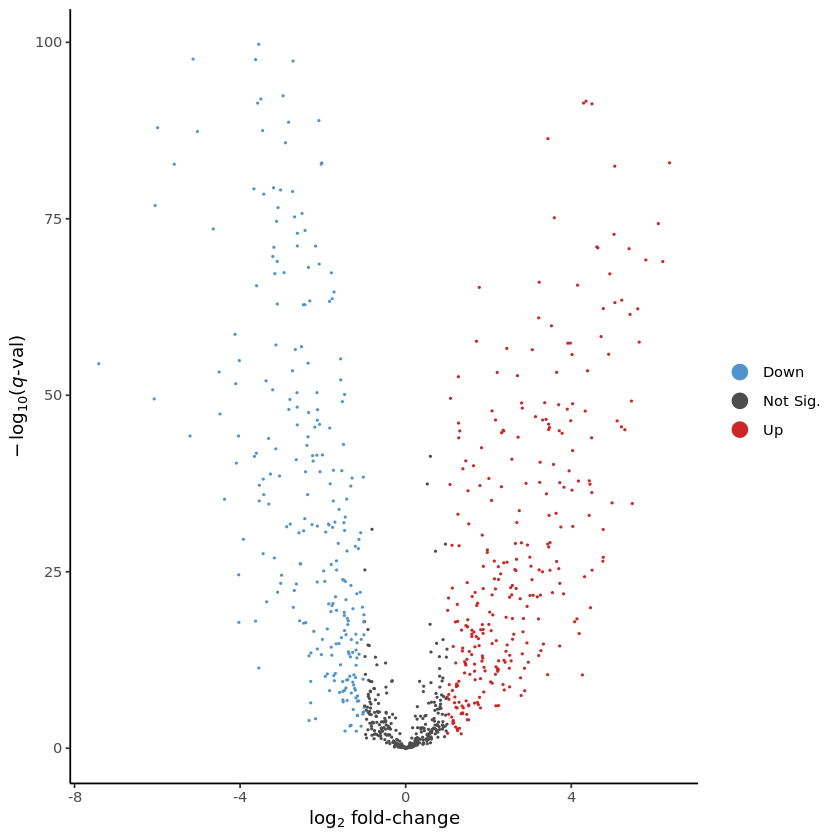

In [9]:
matrisome_summary_df %>%
    to_vplot_df() %>%
    make_vplot()
ggsave(paste0(dirs$figures_dir, "/deg/", dsets[dset_idx], "_matrisome_genes_vplot.png"), last_plot(), height = vp_ht, width = vp_wd, dpi = dpi)

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label

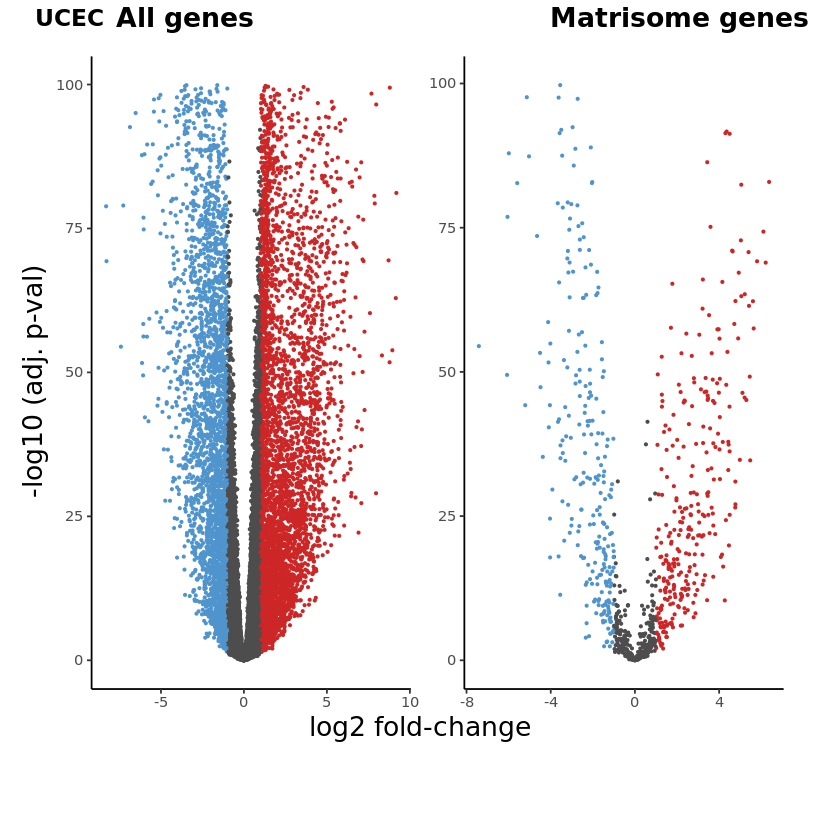

In [10]:
p1 <- dge_res_df %>%
    to_vplot_df() %>%
    make_vplot(point_size = 0.5)
p2 <- matrisome_summary_df %>%
    to_vplot_df() %>%
    make_vplot(point_size = 0.5)
pg1 <- plot_grid(
    p1 + theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank()),
    p2 + theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank()),
    labels = c("All genes", "Matrisome genes"),
    label_size = 16,
#     labels = c("A", "B"),
#     label_size = 16,
    vjust = -1
    ) +
    theme(plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    draw_label("log2 fold-change", size = 16, x = 0.5, y = 0, vjust = 1, angle = 0) +
    draw_label("-log10 (adj. p-val)", size = 16, x = 0, y = 0.5, vjust = -0.25, angle = 90)
# pg1
# ggsave(paste0(dirs$figures_dir, "/", dsets[dset_idx], "_combined_vplots.png"), last_plot())
pg2 <- plot_grid(
    pg1,
    labels = c(project[dset_idx]),
#     get_legend(p1),
    nrow = 2,
    rel_heights = c(3, 0.3)
)
pg2
# ggsave(paste0(dirs$figures_dir, "/deg/", dsets[dset_idx], "_combined_vplots.png"), last_plot(), height = 4, width = 8)

# Sankey diagram

In [11]:
sd_df <- matrisome_summary_df %>%
#     mutate(gene_list = rep("Matrisome Genes in Dataset", nrow(matrisome_summary_df))) %>%
    mutate(gene_list = ifelse(in_unified_dataset, "In Dataset", "Non-Matrisome Genes/Not in Dataset")) %>%
    mutate(DEG_cat = ifelse((qval < 0.05 & abs(log2FoldChange) > log2(2) & !lowly_expressed), "Sig. DEGs", "Non-sig./Lowly Expressed")) %>%
    dplyr::select(gene_list, DEG_cat, category)

head(sd_df)

gene_list,DEG_cat,category
<chr>,<chr>,<chr>
In Dataset,Sig. DEGs,ECM Glycoproteins
In Dataset,Sig. DEGs,ECM Glycoproteins
In Dataset,Sig. DEGs,ECM Glycoproteins
In Dataset,Sig. DEGs,ECM Glycoproteins
In Dataset,Non-sig./Lowly Expressed,ECM Glycoproteins
In Dataset,Non-sig./Lowly Expressed,ECM Glycoproteins


In [12]:
matrisome_summary_grouped_df <- matrisome_summary_df %>%
    group_by(category) %>%
    mutate(category = replace(category, category == "ECM Glycoproteins", "Glycoproteins (ECM)")) %>%
    mutate(category = replace(category, category == "ECM Regulators", "Regulators (ECM)")) %>%
    summarize(tot_n = n())
# matrisome_summary_grouped_df

source_v = c()
target_v = c()
value_v = c()

# gene list -> DEG cat
sd1_df <- sd_df %>%
    group_by(gene_list, DEG_cat) %>%
    dplyr::filter(gene_list == "In Dataset") %>%
    summarize(n = n()) %>%
#     mutate(gene_list_with_n = paste0(gene_list, ": ", sum(n[gene_list == "Matrisome Genes in Dataset"]))) %>%
    mutate(gene_list_with_n = paste0(gene_list, ": ", sum(n))) %>%
    mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", n))
sd1_df

source_v <- c(source_v, sd1_df$gene_list_with_n)
target_v <- c(target_v, sd1_df$DEG_cat_with_n)
value_v <- c(value_v, sd1_df$n)



# DEG cat -> category
sd2_df <- sd_df %>%
    mutate(category = replace(category, category == "ECM Glycoproteins", "Glycoproteins (ECM)")) %>%
    mutate(category = replace(category, category == "ECM Regulators", "Regulators (ECM)")) %>%
    group_by(DEG_cat, category) %>%
    dplyr::filter(DEG_cat == "Sig. DEGs") %>%
    summarize(n = n()) %>%
    mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", sum(n))) %>%
    mutate(category_with_n = paste0(category, ": ", n)) %>%
    dplyr::inner_join(matrisome_summary_grouped_df, by = "category") %>%
    dplyr::mutate(category_pct = round(n / tot_n * 100, 0)) %>%
    dplyr::mutate(category_with_n_and_pct = paste0(category_with_n, " (", category_pct, "%)"))
    
sd2_df

source_v <- c(source_v, sd2_df$DEG_cat_with_n)
target_v <- c(target_v, sd2_df$category_with_n_and_pct)
value_v <- c(value_v, sd2_df$n)

`summarise()` has grouped output by 'gene_list'. You can override using the `.groups` argument.



gene_list,DEG_cat,n,gene_list_with_n,DEG_cat_with_n
<chr>,<chr>,<int>,<chr>,<chr>
In Dataset,Non-sig./Lowly Expressed,390,In Dataset: 1008,Non-sig./Lowly Expressed: 390
In Dataset,Sig. DEGs,618,In Dataset: 1008,Sig. DEGs: 618


`summarise()` has grouped output by 'DEG_cat'. You can override using the `.groups` argument.



DEG_cat,category,n,DEG_cat_with_n,category_with_n,tot_n,category_pct,category_with_n_and_pct
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<chr>
Sig. DEGs,Collagens,29,Sig. DEGs: 618,Collagens: 29,44,66,Collagens: 29 (66%)
Sig. DEGs,ECM-affiliated Proteins,99,Sig. DEGs: 618,ECM-affiliated Proteins: 99,171,58,ECM-affiliated Proteins: 99 (58%)
Sig. DEGs,Glycoproteins (ECM),121,Sig. DEGs: 618,Glycoproteins (ECM): 121,195,62,Glycoproteins (ECM): 121 (62%)
Sig. DEGs,Proteoglycans,24,Sig. DEGs: 618,Proteoglycans: 24,35,69,Proteoglycans: 24 (69%)
Sig. DEGs,Regulators (ECM),143,Sig. DEGs: 618,Regulators (ECM): 143,238,60,Regulators (ECM): 143 (60%)
Sig. DEGs,Secreted Factors,202,Sig. DEGs: 618,Secreted Factors: 202,344,59,Secreted Factors: 202 (59%)


In [13]:
links_df <- tibble(
    source = source_v,
    target = target_v,
    value = value_v,
)

nodes_df <- tibble(
    name = c(links_df$source, links_df$target) %>% unique()
)

links_df$sourceID <- match(links_df$source, nodes_df$name) - 1
links_df$targetID <- match(links_df$target, nodes_df$name) - 1

In [14]:
sn <- sankeyNetwork(
    Links = links_df,
    Nodes = nodes_df,
    Source = "sourceID",
    Target = "targetID",
    Value = "value",
    NodeID = "name",
    fontSize = 46,
    fontFamily = "calibri",
    sinksRight = FALSE
)

Links is a tbl_df. Converting to a plain data frame.

Nodes is a tbl_df. Converting to a plain data frame.



In [15]:
sn
saveNetwork(sn, paste0(dirs$figures_dir, "/deg/", dsets[dset_idx], "_matrisome_sankey_diagram.html"))

HTML widgets cannot be represented in plain text (need html)